# Улучшение качества кластеризации

В рамках анализа данных и машинного обучения нередко возникают ситуации, в которых просто необходимо использовать продвинутые методы визуализации данных, чтобы получить качественные результаты. Чаще всего необходимость в качественной визуализации возникает при работе с алгоритмами кластеризации.

Задача этого модуля — научить использовать визуализации для быстрого улучшения качества классификации.

Это поможет сконцентрировать свое внимание непосредственно на улучшении качества полученных результатов, не переживая о поиске наиболее эффективных инструментов визуализации и наглядно следить за тем, как доработка модели влияет на качество результатов.

В рамках этого модуля мы обсудим применение визуализации при работе с алгоритмами k-Nearest Neighbors и Random Forest, а также при выводе результатов, полученных в модели. Все эти модели вы уже ранее изучали в рамках курса по машинному обучению. Поэтому мы не будем фокусироваться на теории, но попробуем реализовать собственный алгоритм и разберемся насколько возможно использовать визуализацию с собственными алгоритмами.

Представьте: вы работаете в большом агрохолдинге, который выращивает декоративные растения: тюльпаны, ирисы, розы и подобное, на продажу. У вас есть проблема: вы закупаете сырьё у местных фермеров, и они часто путают сорта цветов. У вас есть штат специалистов, которые вручную проверяют партии, но это долго и дорого. Вам поручили собрать алгоритм, который делал бы это автоматически при приёмке
(на самом деле, это могут быть алгоритмы определения и спелости помидор, и качества руды — просто у нас есть классический датасет с [ирисами](https://en.wikipedia.org/wiki/Iris_(plant)), поэтому сегодня мы работаем с агрохолдингом).

За работу!

# 1. Метод k-Nearest Neighbors

Начнем повторение алгоритмов классификации с наиболее распространенного метода классификации в ML - метода k-ближайших соседей (kNN). Его достаточно просто реализовать в отличие от других алгоритмов, поэтому для наглядности, мы сначала напишем собственную реализацию и посмотрим на результаты, применив метод к стандартному датасету Iris, а затем сравним с библиотечной реализацией из библиотеки *sklearn*.

*Напоминание:*
*Метод kNN относится к разряду ленивых классификаторов. Это значит, что метод "обучается" лишь на новых данных, не учитывая предыдущий опыт. То есть, в процессе обучения алгоритм не делает ничего, а только сохраняет размеченные тренировочные данные. Сам процесс классификации начинается только тогда, когда появляются новые немаркированные данные - алгоритм по определенным признакам считает расстояния между уже размеченными и еще неизвестными объектами в пространстве.*

Импортируем датасет Iris из библиотеки sklearn.
Он представляет собой собрание морфологических измерений разных сортов ирисов. Каждое растение имеет 4 характеристики:
- длина чашелистика
- ширина чашелистика
- длина лепестка
- ширина лепестка

P.S. Кстати, изначально этот датасет был собран лично Рональдом Фишером. Мы обязаны ему половиной статистического аппарата, который мы используем до сих пор. Он, среди прочего придумал дисперсию и F-test.

In [ ]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

iris_dataset = load_iris() # возвращает объект с несколькими полями

Посмотрим, что включает в себя набор данных.

In [ ]:
iris_dataset.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

К сожалению, судя по тому, что работает метод `.keys()`, датасет представлен в формате аналога словаря из sklearn, поэтому нельзя использовать все те методы, которые доступны для `pandas.DataFrame`. Нужно это исправлять :)

Посмотрим, в каком формате представлен словарь:

In [ ]:
type(iris_dataset)

sklearn.utils._bunch.Bunch

Ага, мы имеем дело с отдельным типом данных `Bunch`, реализованном в библиотеке `sklearn`. Для удобства работы нам нужно посмотреть, к какому типу относятся отдельные переменные внутри этой структуры. Если они нам не подойдут, то стоит изменить форматирование.

Посмотрим на то, какие типа ирисов представлены в датасете и какие фичи нам доступны.

In [ ]:
iris_dataset['target_names'] # виды ирисов

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

Судя по тому, что мы видим ключевое слово `array`, этот столбец представляет собой массив из библиотеки `numpy`.

In [ ]:
iris_dataset['feature_names'] # характеристики каждого цветка

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

А вот этот столбец уже является обычным Python-списком.

Теперь давайте посмотрим разметку датасета и количество данных.

In [ ]:
print(iris_dataset['target'].shape) # каждый цветок соответствует виду
iris_dataset['target'] # 0 - setosa, 1 - versicolor, 2 - virginica

(150,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [ ]:
print(type(iris_dataset['data']))
iris_dataset['data'].shape # всего 150 цветков, у каждого 4 измерения

<class 'numpy.ndarray'>


(150, 4)

Теперь перейдем к главному - перед анализом давайте построим визуализацию, которая позволит нам зрительно оценить различия среди разных видов ириса.
Ранее мы обсуждали с вами такой модуль библиотеки Pandas как `pandas.plot`. Помимо этого модуля Pandas также предоставляет другой, более продвинутый модуль - `pandas.plotting`, позволяющий в том числе строить графики на основе всего датасета, а не отдельных столбцов. Подробнее с модулем рекомендуем ознакомиться [здесь](https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html#plotting-tools).

Один из таких графиков называется `scatter_matrix`, который позволяет визуализировать корреляцию между всеми числовыми характеристиками в датасете. Как и многие другие датасеты, он поддерживает возможность окрашивания каждой точки в разный цвет в соответствии с данными какого-то столбца. Причем эта характеристика может быть как категориальная, так и численная. За это отвечают параметры `c` и `s` (мы будем использовать параметр `c`, про отличия между ними можно почитать [здесь](https://stackoverflow.com/questions/52412449/pandas-plot-argument-c-vs-s)).

Но поскольку для работы нам необходим DataFrame, сначала нужно сконвертировать датасет:

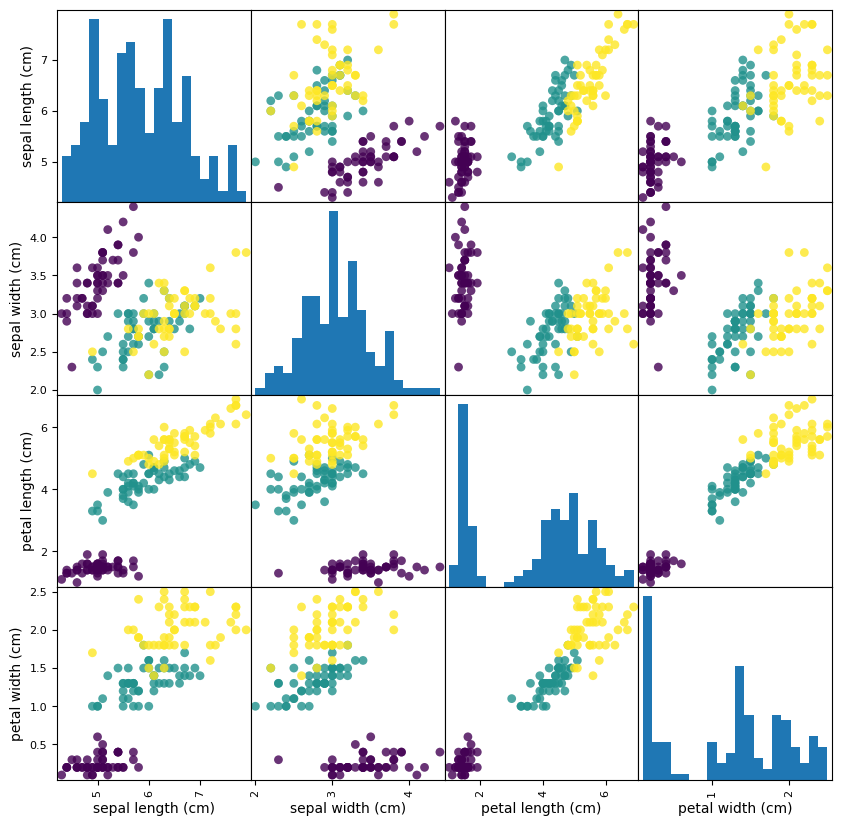

In [ ]:
import pandas as pd

iris_dataframe = pd.DataFrame(iris_dataset['data'], columns=iris_dataset.feature_names)
scat_mtrx = pd.plotting.scatter_matrix(iris_dataframe, c=iris_dataset['target'], figsize=(10, 10), marker='o',
                                       hist_kwds={'bins': 20}, s=40, alpha=.8)

По диагонали расположены не корреляции, а гистограммы распределения каждой переменной, что также может очень пригодиться при анализе. В графиках с точками в свою очередь показана зависимость разных показателей друг от друга. Разными цветами выделены разные сорта ириса. Уже визуально мы видим, что сорт, помеченый фиолетовым цветом, сильно отличается от остальных. А значит, наш алгоритм должен хорошо сработать.

Из графиков мы можем заметить, что данные классов, по-видимому, хорошо сепарируются по измерениям лепестков и чашелистиков, поэтому, скорее всего, модель машинного обучения сможет научиться неплохо их разделять. Этот вывод можно сделать просто посмотрев на график - еще до построения самой модели.

Но при четырех параметрах достаточно сложно представить, как расположены объекты относительно друг друга, так как придется работать в четырехмерном пространстве. По графикам видно, что лучше всего цветки разбиваются по измерениям длины и ширины лепестка (petal length, petal width), поэтому для наглядности оставим только эти данные.

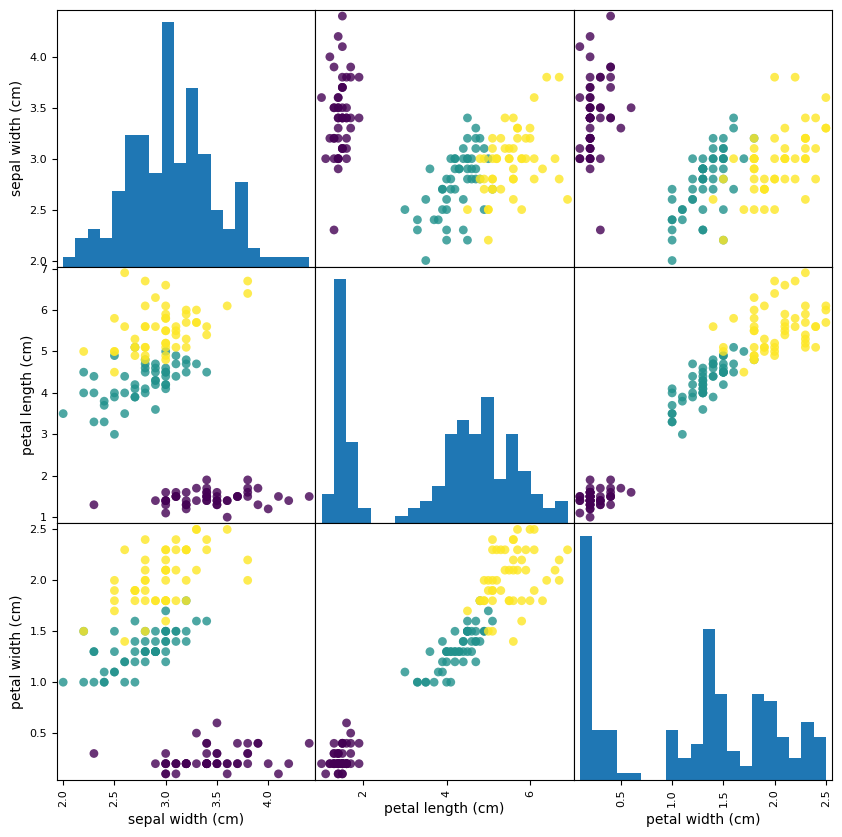

In [ ]:
iris_dataframe_simple = pd.DataFrame(iris_dataset.data[:, 1:4], columns=iris_dataset.feature_names[1:4])
scat_mtrx = pd.plotting.scatter_matrix(iris_dataframe_simple, c=iris_dataset['target'], figsize=(10, 10), marker='o',
                                       hist_kwds={'bins': 20}, s=40, alpha=.8)

Разобьем данные на тренировочный и тестовый датасеты и для простоты реализации алгоритма объединим массивы признаков объектов и метки их классов, чтобы было понятно, к какому классу относится каждый объект.

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(iris_dataset.data[:, 2:4],
                                                    iris_dataset['target'],
                                                    random_state=0) # random_state - для воспроизводимости

print(f'X_train shape: {x_train.shape}, y_train shape: {y_train.shape},\n'
      f'X_test shape: {x_test.shape}, y_test shape: {y_test.shape}')

X_train shape: (112, 2), y_train shape: (112,),
X_test shape: (38, 2), y_test shape: (38,)


In [ ]:
import numpy as np

x_train_concat = np.concatenate((x_train, y_train.reshape(112, 1)), axis=1)
x_test_concat = np.concatenate((x_test, y_test.reshape(38, 1)), axis=1)
print(f'X_train shape: {x_train_concat.shape},\n'
      f'X_test shape: {x_test_concat.shape}')

X_train shape: (112, 3),
X_test shape: (38, 3)


In [ ]:
x_train_concat_df = pd.DataFrame(x_train_concat)
x_test_concat_df = pd.DataFrame(x_test_concat)
x_train_concat_df.head(5)

,0,1,2
0,4.2,1.5,1.0
1,4.0,1.2,1.0
2,5.5,2.1,2.0
3,1.3,0.2,0.0
4,5.1,2.3,2.0


Как мы видим, теперь в последнем столбце у нас присутствуют метки класса.

Приступим к реализации алгоритма.

Для начала определим метрику, по которой будем определять расстояние между объектами. Обозначим через $x = (x_1, x_2, \ldots, x_n)$ координаты объекта $x$ в n-мерном пространстве, а через $y = (y_1, y_2, \ldots, y_n)$ - координаты объекта $y$.

По умолчанию алгоритм использует метрику Минковского, которая в случае степени p = 2 обращается во всем известную из школьной геометрии Евклидову метрику - расстояние между двумя точками в пространстве:
$$
dist = \sqrt{(x_1-y_1)^2 + (x_2 - y_2)^2 + \ldots + (x_n - y_n)^2}
$$
Ее и будем использовать.

In [ ]:
import math

def euclidean_distance(data1, data2):
    distance = 0
    for i in range (len(data1) - 1):
        distance += (data1[i] - data2[i]) ** 2
    return math.sqrt(distance)

Вычислим расстояния до всех точек обучающей выборки и отберем $k$ соседей (то есть тех, расстояния до которых минимальны).

In [ ]:
def get_neighbors(train, test, k=1):
    distances = [(train[i][-1], euclidean_distance(train[i], test))
                  for i in range (len(train))]
    distances.sort(key=lambda elem: elem[1])

    neighbors = [distances[i][0] for i in range (k)]
    return neighbors

Теперь получим прогноз на основе классов соседей. Посчитаем, сколько объектов каждого класса присутствует среди $k$ ближайших к целевому, и затем причислим его к тому классу, экземпляров которого больше всего.

In [ ]:
def prediction(neighbors):
    count = {}
    for instance in neighbors:
        if instance in count:
            count[instance] +=1
        else :
            count[instance] = 1
    target = max(count.items(), key=lambda x: x[1])[0]
    return target

Напишем последнюю функцию для оценки точности прогнозов. О ней речь шла в самом начале - это просто отношение верных прогнозов к общему количеству прогнозов.

In [ ]:
def accuracy(test, test_prediction):
    correct = 0
    for i in range (len(test)):
        if test[i][-1] == test_prediction[i]:
            correct += 1
    return (correct / len(test))

Посмотрим, как работает наш алгоритм.

In [ ]:
predictions = []
for x in range (len(x_test_concat)):
    neighbors = get_neighbors(x_train_concat, x_test_concat[x], k=5)
    result = prediction(neighbors)
    predictions.append(result)
#     print(f'predicted = {result}, actual = {x_test_concat[x][-1]}') # если есть интерес посмотреть, какие конкретно прогнозы некорректны
accuracy = accuracy(x_test_concat, predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9736842105263158


Теперь импортируем библиотечную версию алгоритма.

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

Объект *knn* инкапсулирует алгоритм, который будет использоваться для построения модели из обучающих данных, а также для прогнозирования новых точек данных. Он также будет содержать информацию, которую алгоритм извлек из обучающих данных. В случае *KNeighborsClassifier* он будет просто хранить учебный набор.

Для построения модели на обучающем множестве вызывается метод *fit* объекта *knn*, который принимает в качестве аргументов массив NumPy *x_train*, содержащий обучающие данные, и массив NumPy *y_train* соответствующих обучающих меток.

In [ ]:
knn_model = knn.fit(x_train, y_train)

Для предсказаний вызывается метод *predict*, который в качестве аргументов принимает тестовые данные.

In [ ]:
knn_predictions = knn.predict(x_test)
knn_predictions

array([2, 1, 0, 2, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 0, 2, 1,
       0, 0, 2, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 0, 2])

Для проверки импортируем простую встроенную метрику *accuracy_score*, которая определяет долю правильных ответов.

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, knn_predictions)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9736842105263158


Поскольку в этом случае мы получили идентичные результаты работы алгоритма, можно сделать вывод, что мы точно так же можем использовать визуализацию для проверки работы алгоритма.

Как мы видим, реализованный вручную алгоритм при данных параметрах по точности сопоставим с библиотечной моделью, однако на практике стоит пользоваться именно готовыми реализациями, так как зачастую они гораздо лучше оптимизированы и быстрее/лучше работают с большими выборками данных.

Интересно, что в нашем случае мы смогли точно установить с помощью визуализации, что наша модель сможет хорошо классифицировать имеющиеся у нас данные. Иногда просто построив визуализацию, мы сможем понять, что нет никакого смысла тратить время и силы на построение моделей.

Итак, наша работа сделана! Мы реализовали модель, которую сможет использовать лаборатория для того, чтобы классифицировать те образцы ириса, которые еще не распределены. Однако, насколько сильно мы можем доверять нашей модели? Когда она работает лучше, а когда хуже? Возможно стоит использовать другую модель?

# 2. Визуализация полученных моделью результатов


Иногда нам может пригодится более подробная статистика по качеству модели, чем показатель Accuracy. Зачастую нас интересует количество False Positive и False Negative. Для того, чтобы лучше понять, когда лучше использовать тот или иной способ оценки качества классификации, обратитесь к [этому конспекту](https://colab.research.google.com/drive/1akBl67NnhnOvK_ytSpxIJsUWm3-TBt5o?usp=sharing).

Например, в нашем датасете 95% наблюдений относятся к первому классу (шум), и всего 5% наблюдений - это те наблюдения, которые нас интересуют (второй класс). После обучения модель выбрала стратегию - относить все наблюдения к первому классу. В таком случае accuracy модели будет 95%, но фактически такая модель бесполезна и не может никак нам помочь.

Здесь на помощь может прийти построение визуализации `sns.heatmap`:

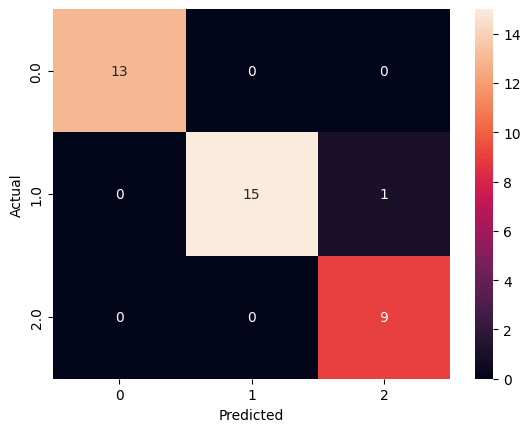

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Создаем столбец с предсказаниями на основе наших фичей
predicted_classes = knn_model.predict(x_test_concat_df.iloc[:, :2])

# Добавим получившийся столбец в конец нашего датасета
x_test_concat_df['Predicted_Class'] = predicted_classes

# Создадим на основе нашего датасета матрицу соответствия
confusion_matrix = pd.crosstab(x_test_concat_df[2], x_test_concat_df['Predicted_Class'], rownames=['Actual'], colnames=['Predicted'])

# Построим sns.heatmap
sns.heatmap(confusion_matrix, annot=True, fmt='d')
plt.show()

Как мы видим, в нашем случае всего одно ложное срабатываение - первый класс был определен как второй. Если вы вспомните нашу визуализацию, проведенную ранее, то сразу же поймете почему так произошло. Эти два класса пересекаются - самые большие образцы первого класса находятся очень близко к самым маленьким образцам второго. Поэтому в одном из шестнадцати случаев наша модель все-таки ошиблась.

Теперь вы знаете как использовать визуализацию для того, чтобы лучше использовать понимать и использовать алгоритмы классификации.

# 3. Decision Tree и его визуализация

Давайте попробуем решить ту же задачу, используя другие методы классификации.
Один из самых популярных методов классификации - это алгоритм случайного леса. С его помощью можно получить достаточно точные результаты. Однако, есть определенная проблема - из-за его внутренней структуры, его достаточно сложно визуализировать. Однако это возможно!

Давайте попробуем это сделать:

In [ ]:
# Применим алгоритм решающего дерева к нашему датасету
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

X = iris_dataset.data
y = iris_dataset.target
clf = DecisionTreeClassifier(random_state=1234)
model = clf.fit(X, y)

In [ ]:
# Попробуем посмотреть на полученные результаты в текстовом виде
text_representation = tree.export_text(clf)
print(text_representation)

|--- feature_2 <= 2.45
|   |--- class: 0
|--- feature_2 >  2.45
|   |--- feature_3 <= 1.75
|   |   |--- feature_2 <= 4.95
|   |   |   |--- feature_3 <= 1.65
|   |   |   |   |--- class: 1
|   |   |   |--- feature_3 >  1.65
|   |   |   |   |--- class: 2
|   |   |--- feature_2 >  4.95
|   |   |   |--- feature_3 <= 1.55
|   |   |   |   |--- class: 2
|   |   |   |--- feature_3 >  1.55
|   |   |   |   |--- feature_0 <= 6.95
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_0 >  6.95
|   |   |   |   |   |--- class: 2
|   |--- feature_3 >  1.75
|   |   |--- feature_2 <= 4.85
|   |   |   |--- feature_1 <= 3.10
|   |   |   |   |--- class: 2
|   |   |   |--- feature_1 >  3.10
|   |   |   |   |--- class: 1
|   |   |--- feature_2 >  4.85
|   |   |   |--- class: 2



Как мы видим, полученные результаты можно интерпретировать исходя из этого текста, но это очень затруднительно - ветвящаяся структура сильно усложняет восприятие. Но тут на помощь приходит визуализация - то же самое возможно изобразить с помощью диаграммы в более читаемом виде. Уже созданные пресет такой диаграммы реализован в классе `tree` библиотеки `scikit.learn`.
Давайте создадим подобную диаграмму:

In [ ]:
iris_dataset.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

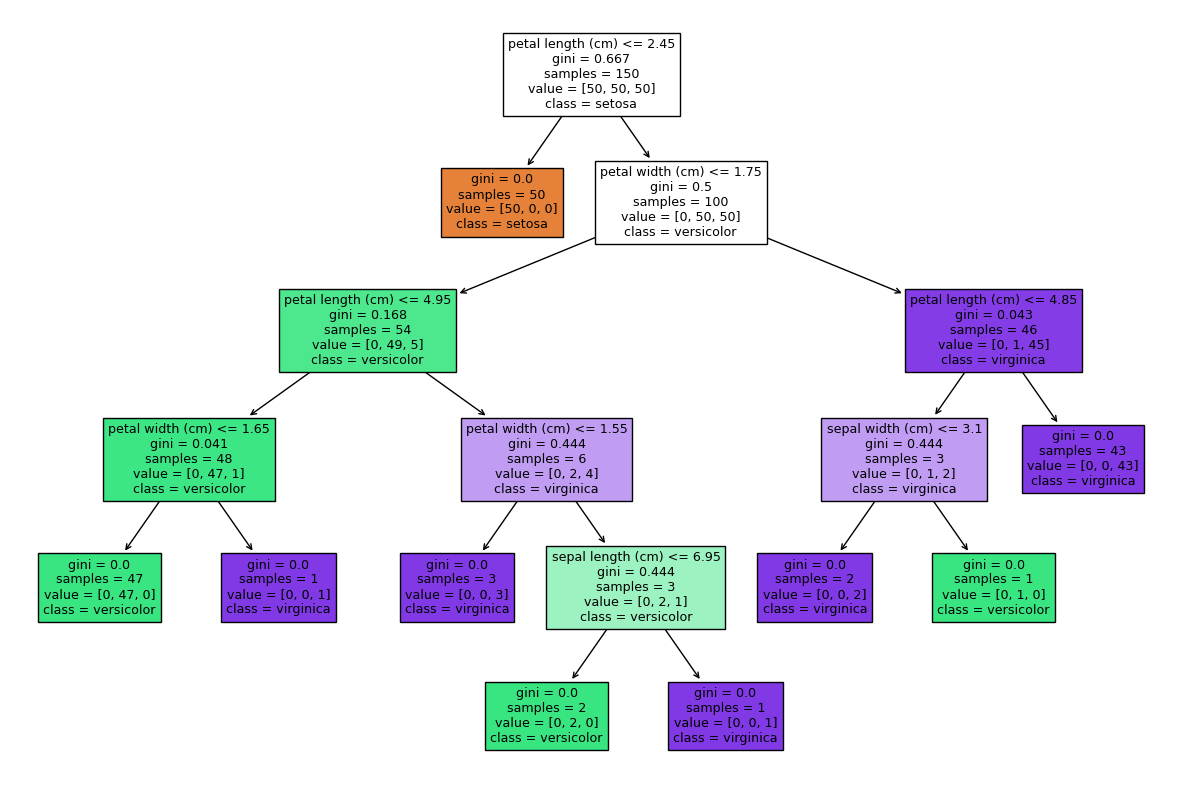

In [ ]:
fig = plt.figure(figsize=(15,10))
_ = tree.plot_tree(clf,
                   feature_names=iris_dataset.feature_names,
                   class_names=iris_dataset.target_names,
                   filled=True)

Вот, так намного лучше! Теперь можно отследить принцип работы алгоритма в удобном и наглядном виде.

Конечно, у этого метода есть свои ограничения - например, если дерево слишком большое, с большим количеством признаком, то визуализация получился слишком громоздкой и сложно интерпретируемой, однако это все равно может быть полезно.

Кстати, полученные результаты можно сохранить как png-картинку с помощью следующего кода:

`fig.savefig("decistion_tree.png")`


Есть и другие библиотеки, которые позволят визуализировать полученные результаты, вы можете выбрать что вам по душе.

Первая такая библиотека называется `graphviz`:

In [ ]:
# Если у вас не установлен данный модуль
!pip install graphviz

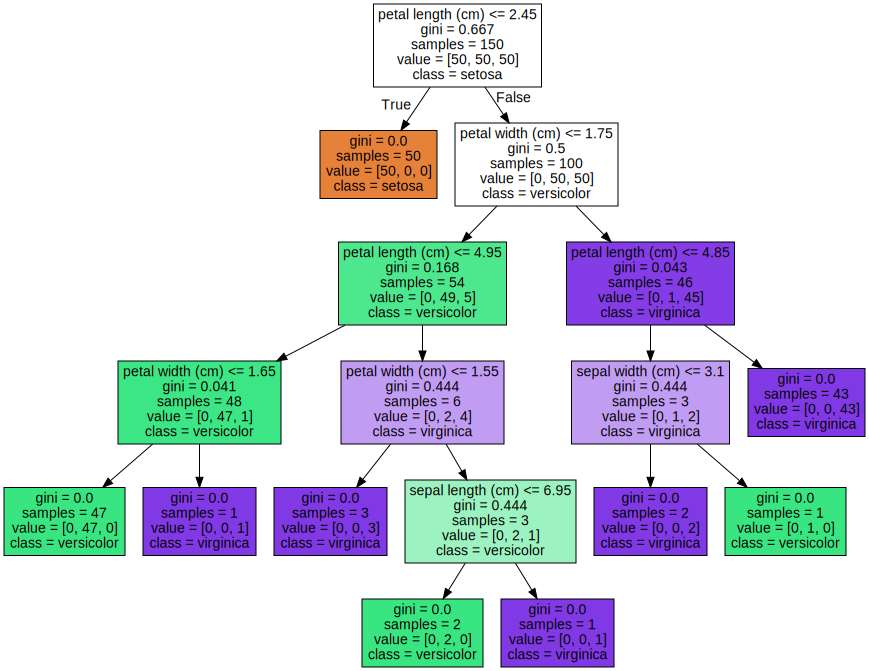

In [ ]:
import graphviz

dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=iris_dataset.feature_names,
                                class_names=iris_dataset.target_names,
                                filled=True)

# Draw graph
graph = graphviz.Source(dot_data, format="png")
graph


Полученные результаты похожи на те, что предоставляет `scikit.learn`, но они более "сжатые" и лаконичные. Кроме того, здесь эксплицитно указано какая стрелка отвечает за выполнение условия `True`, а какая за `False`.

Есть еще один популярный модуль, который сильно отличается от двух предыдущих, он называется `dtreeviz` - вы можете ознакомиться с ним на [GitHub'е](https://github.com/parrt/dtreeviz) авторов. Этот модуль представляет наиболее продвинутые методы визуализации решающих деревьев и некоторых других методов.  

К сожалению, существуют сложности с визуализацией алгоритма случайного леса (совокупности разных деревьев), однако вы всегда можете визуализировать каждое решающее дерево по-отдельности.

Некоторые другие методы классификации также поддаются классификации, но мы не будем рассматривать их отдельно. Один из таких методов - Support Vector Machines (SVM). Реализацию визуализации работы этого алгоритма на том же датасете вы можете посмотреть по этой [ссылке](https://www.kaggle.com/code/xopxesalmon/svm-2dimension-hyperplane-visualization).

In [ ]:
from sklearn.datasets import load_iris

In [ ]:

iris = load_iris()

In [ ]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 1.3 MB/s eta 0:00:00


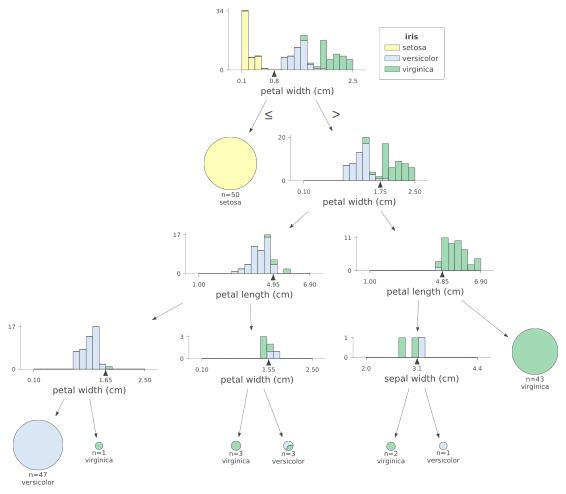

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

import dtreeviz

iris = load_iris()
X = iris.data
y = iris.target

clf = DecisionTreeClassifier(max_depth=4)
clf.fit(X, y)

viz_model = dtreeviz.model(clf,
                           X_train=X, y_train=y,
                           feature_names=iris.feature_names,
                           target_name='iris',
                           class_names=iris.target_names)

v = viz_model.view()     # render as SVG into internal object
v.show()                 # pop up window
v.save("iris.svg")  # optionally save as svg
viz_model.view()       # in notebook, displays inline

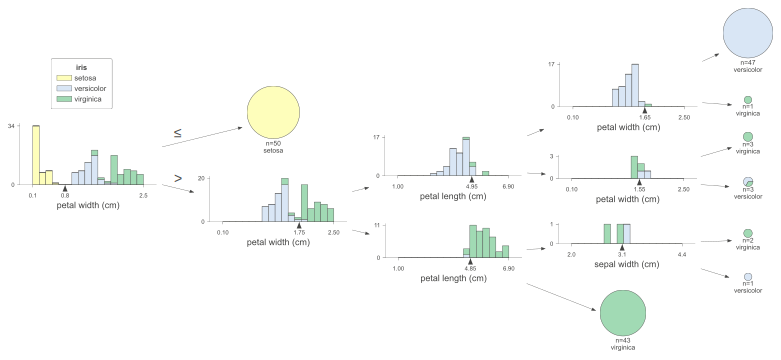

In [ ]:
viz_model.view(orientation="LR")

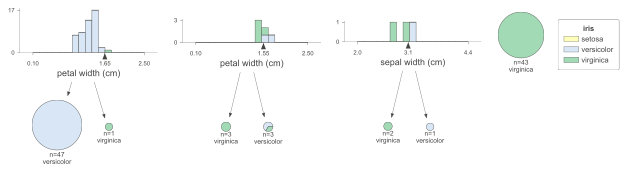

In [ ]:
viz_model.view(depth_range_to_display=(3, 4))

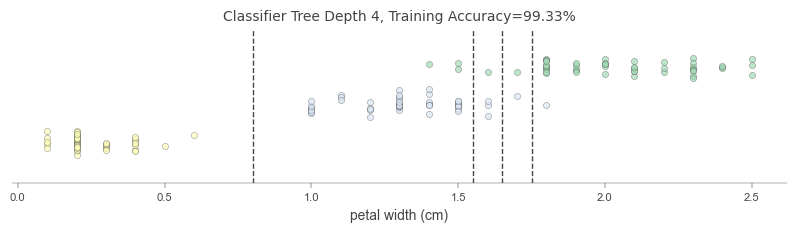

In [ ]:
viz_model.ctree_feature_space(show={'splits','title'}, features=['petal width (cm)'],
                             figsize=(10,2))

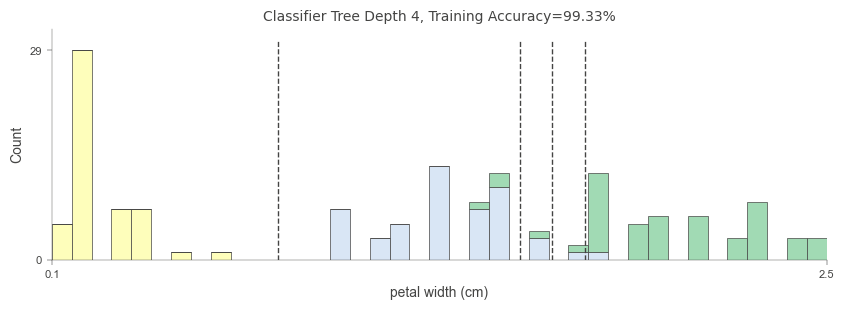

In [ ]:
viz_model.ctree_feature_space(nbins=40, gtype='barstacked', show={'splits','title'}, features=['petal width (cm)'],
                             figsize=(10,3))

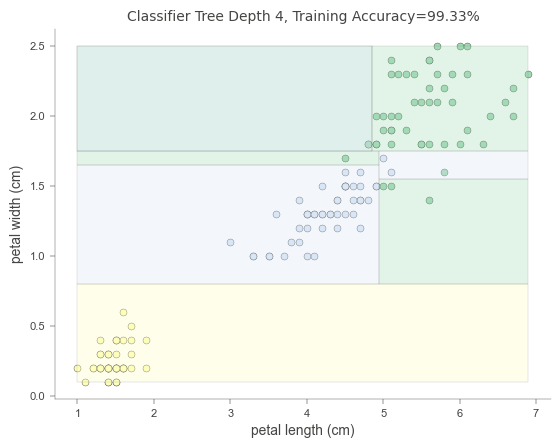

In [ ]:
viz_model.ctree_feature_space(show={'splits','title'}, features=['petal length (cm)', 'petal width (cm)'])


## Визуализация регрессии при работе с деревьями

In [ ]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

dataset_url = "https://raw.githubusercontent.com/parrt/dtreeviz/master/data/cars.csv"
df_cars = pd.read_csv(dataset_url)
X = df_cars.drop('MPG', axis=1)
y = df_cars['MPG']
features = list(X.columns)

dtr_cars = DecisionTreeRegressor(max_depth=3, criterion="absolute_error")
dtr_cars.fit(X.values, y.values)

viz_rmodel = dtreeviz.model(dtr_cars, X, y,
                            feature_names=features,
                            target_name='MPG')

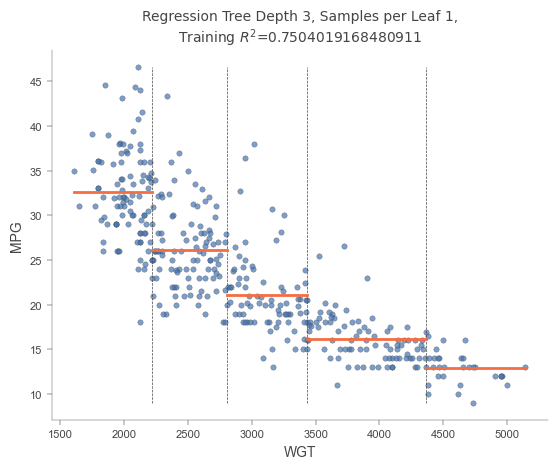

In [ ]:
viz_rmodel.rtree_feature_space(features=['WGT'])

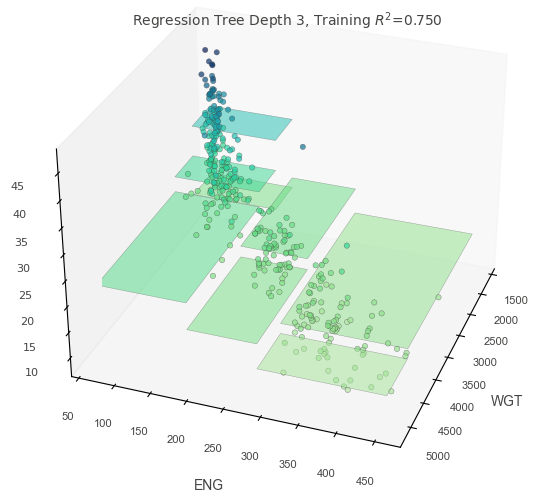

In [ ]:
viz_rmodel.rtree_feature_space3D(features=['WGT','ENG'],
                                 fontsize=10,
                                 elev=30, azim=20,
                                 show={'splits', 'title'},
                                 colors={'tessellation_alpha': .5})

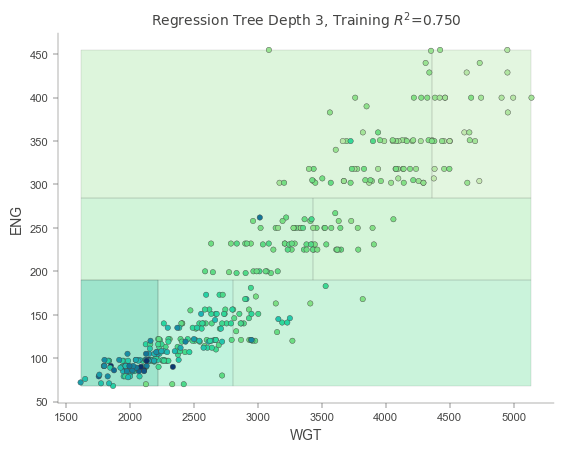

In [ ]:
viz_rmodel.rtree_feature_space(features=['WGT','ENG'])

# 4. Визуализация результатов работы алгоритма градиентного спуска

Один из важных алгоритмов машинного обучения - градиентный спуск. Основная проблема данного алгоритма - он предназначен для нахождения локального минимума/максимума, а не глобального. Однако алгоритм очень полезен в ряде задач. (Кроме того, глобальный минимум можно найти запустив несколько алгоритмов градиентного спуска)

Давайте самостоятельно напишем алгоритм градиентного спуска и создадим динамическую визуализацию, которая позволит следить за работой алгоритма.

## Визуализация градиентного спуска на двухмерном графике

Для начала реализуем функции, необходимые нам для визуализации.

Визуализация функции одной переменной:

In [ ]:
def plot_1d_fuction(xs: list, ys: list, title: str, figsize=(15, 5)):
    '''
    xs – значения функции по x
    ys – значения функции по y
    title – заголовок картинки
    msg – информация для отображения на картинке
    figsize – размер картинки
    '''

    plt.figure(figsize=figsize)
    plt.plot(xs, ys, 'b')
    plt.title(title)
    plt.ylabel('$f(x)$')
    plt.xlabel('$x$');

Функция для отрисовки графика и значение функции в точке x:

---


In [ ]:
from IPython.display import clear_output

def plot_line_with_x(xs: list, ys: list, x: float, fx: float, title: str, msg='', figsize=(15, 5)):
    '''
    xs – значения функции по x
    ys – значения функции по y
    x – текущее положение точки по x
    fx – текущее положение точки по y
    title – заголовок картинки
    msg – информация для отображения на картинке
    figsize – размер картинки
    '''

    clear_output(True)
    plt.figure(figsize=figsize)
    plt.plot(xs, ys, 'b')
    plt.scatter([x], [fx], c='r', marker='x', s=120)

    plt.title(title)
    plt.ylabel('$f(x)$')
    plt.xlabel('$x$')
    plt.text(s=msg, x=-2, y=103)
    plt.show()

<p>Давайте начнем с поиска минимума полинома шестой степени

$$(f(x) = x^6 + 3x^5 - 15x^3-24x^2+15x-10)$$

Для этого нам нужно воспользоваться стандартным алгоритмом градиентного спуска, для которого понадобится найти производную.

Если вы забыли как работает градиентный спуск, об этом можно почитать, например, [здесь](https://habr.com/ru/articles/716380/).

Реализуем функцию вычисления значений $f(x)$:

In [ ]:
def f_1d(x):
    return (x ** 6) + 3 * (x ** 5) - 15 * (x ** 3) - 24 * (x ** 2) + 15 * x - 10

Нарисуем график функции на отрезке от -3 до 2.5:

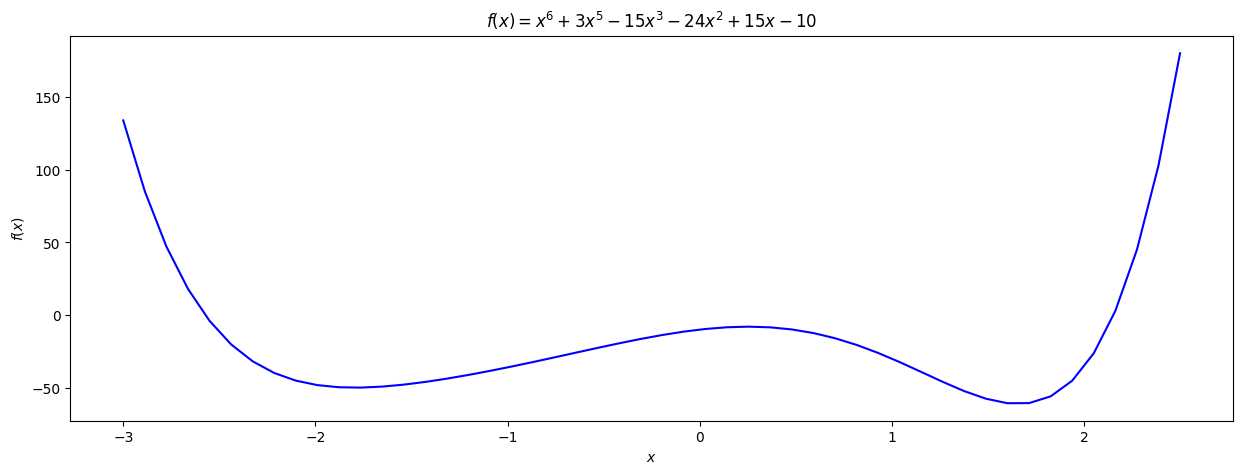

In [ ]:
title_f_1d = '$f(x) = x^{6} + 3x^{5} - 15x^{3} - 24x^{2} + 15x - 10$'

xs = np.linspace(-3, 2.5)
ys = f_1d(xs)

plot_1d_fuction(xs, ys, title=title_f_1d)

Мы видим, что у функции 2 минимума.

<p>Алгоритм градиентного спуска в самом общем виде выглядит так:</p>

<p><code>until converge:<br />
&nbsp; &nbsp; x = x - alpha * grad(f(x))</code></p>

<p>где <code>alpha</code> &mdash; это скорость обучения (то, как сильно мы меняем своё положение на каждом шаге), а <code>`grad(f(x))</code> &mdash; производная от функции $f(x)$. </p>


<p>Реализуем функцию для вычисления производной в нужной нам точке, используя школьный алгоритм производной степени:</p>

In [ ]:
def grad(x):
    return 6 * x ** 5 + 15 * x ** 4 - 45 * x ** 2 - 48 * x + 15

<p>Всё готово для поиска минимума функции методом градиентного спуска.

<p>Начнем с точки $x_0=0.2$, величину шага $\alpha$ примем равной $0.03$ и будем останавливать итерации, если абсолютное значение градиента не превышает $10^{-4}$ (параметр $tol$).

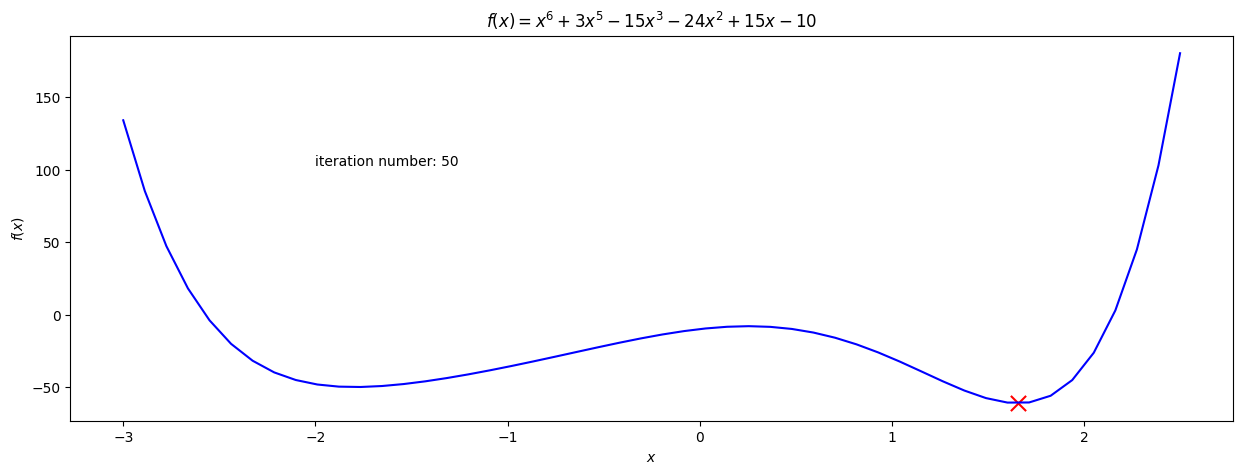

In [ ]:
alpha = 0.03
tol = 1e-4

x = 10

max_iteration = 200
iteration = 0

dfdx = np.clip(grad(x), -10, 10)
dfdx_sign = np.sign(dfdx)

for i in range(max_iteration):
    if abs(dfdx) < tol:
      break

    dfdx = np.clip(grad(x), -10, 10)
    x = x - alpha * dfdx
    iteration += 1

    if dfdx_sign != np.sign(dfdx):
      alpha = alpha / 1.3

    dfdx_sigh = np.sign(dfdx)
    plot_line_with_x(xs, ys, x, f_1d(x), msg=f'iteration number: {iteration}', title=title_f_1d)



Можете поиграться с параметром x и посмотреть результаты, которые получились бы в графике, если изменить начальную точку.

# 5. Заключение

Таким образом, в рамках этого модуля:
- Мы узнали, что благодаря встроенной в `Pandas` функции `pd.plotting.scatter_matrix` можно строить графики для визуализации корреляций и распределений на одном удобном полотне.
- Используя формулу, реализовали алгоритм `kNN` и сравнили результаты с библиотечной функцией - они оказались идентичными. Для того, чтобы использовать этот алгоритм, можно импортировать функцию `KNeighborsClassifier` из библиотеке `sklearn.neighbors`.
- Для анализа полученных алгоритмом классификации результатов обычно используют так называемую `Confusion Matrix` (Матрица Несоответствий, создается с помощью `pd.crosstab`). Эта таблица нужна для того, чтобы отслеживать какие классы были неправильно аттрибутированы и где возникает главная путаница. Для того, чтобы лучше проанализировать и визуализировать Confusion Matrix, можно использовать `sns.heatmap()`.
- Один из самых сложных для визуализации алгоритмов - `Decision Tree`. Это связанно с архитектурой алгоритма. Получить схему с результатами можно с помощью функции `tree.export_text(df)`.
- Однако, такой способ не представляется удобным. Очень сложно разобраться в результатах с такой схемой. На помощь приходит функция `tree.plot_tree()` библиотеки `sklearn`, позволяющая визуализировать полученные результаты в виде нисходящего дерева вариантов. Более продвинутую и удобную версию такой визуализации предоставляет библиотека `graphviz`, благодаря которой можно получить подробные сведения о результатах работы модели.
- С помощью линейного графика можно создать визуализацию работы градиентного спуска.
